In [129]:
from pynq import Overlay
from pynq import MMIO
import pynq.lib.dma
from pynq import allocate
import numpy as np
import struct
from time import time

from matplotlib import pyplot as plt

In [130]:
from pynq import Overlay

overlay = Overlay('/home/xilinx/pynq/overlays/User_overlay/PYNQ_CNN.bit')

In [131]:
overlay.is_loaded()

True

In [132]:
from pynq import Clocks

print(f'CPU:   {Clocks.cpu_mhz:.6f}MHz')
print(f'FCLK0: {Clocks.fclk0_mhz:.6f}MHz')
print(f'FCLK1: {Clocks.fclk1_mhz:.6f}MHz')
print(f'FCLK2: {Clocks.fclk2_mhz:.6f}MHz')
print(f'FCLK3: {Clocks.fclk3_mhz:.6f}MHz')

CPU:   650.000000MHz
FCLK0: 100.000000MHz
FCLK1: 100.000000MHz
FCLK2: 100.000000MHz
FCLK3: 100.000000MHz


In [134]:
ip = overlay.myproject_axi_0

In [135]:
ip.register_map

RegisterMap {
  Memory_in_V = Register(value=0),
  Memory_out_V = Register(value=34603092)
}

In [136]:
print("Memory_in_V.address: " + str(ip.register_map.Memory_in_V.address))
print("Memory_out_V.address: " + str(ip.register_map.Memory_out_V.address))

Memory_in_V.address: 2048
Memory_out_V.address: 4096


In [137]:
in_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_in_V.address, 392 * 4)
ou_mmio = MMIO(ip.mmio.base_addr + ip.register_map.Memory_out_V.address, 5 * 4)

In [202]:
X = np.load('./X_test.npy').astype(np.float32)
X = X[:5]

In [198]:
def encode_matrix(matrix):
    X_ca = np.reshape(matrix*2**10, (392,2))
    X_ca = X_ca.astype(np.uint16)
    X_enc = []
    for i in range(X_ca.shape[0]):
        X_enc.append(X_ca[i][0] + X_ca[i][1]*2**16)
    X_enc = np.array(X_enc, dtype=np.uint32)
    
    return X_enc

def decode(yi):
    return yi * 2**-10

def decode_pair(yab):
    ya = (yab & 0x0000ffff) * 2**-10
    ya = ya if ya < 32 else ya - 64
    yb = (yab & 0xffff0000) * 2**-26
    yb = yb if yb < 32 else yb - 64
    return ya, yb

def get_output(mmio):
    y = np.zeros(10)
    for i in range(5):
        yi = decode_pair(mmio.read(4 * i))
        y[2*i], y[2*i+1] = yi[0], yi[1]
    return y[:10]

def print_img(matrix, title="Label"):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

    
def print_dt(timea, timeb, N):
    dt = (timeb - timea) 
    rate = N / dt
    print("Classified {} images in {} seconds ({} inferences / s)".format(N, dt, rate))
    print("----------------------------------------------------------------------------")
    print("{} s/inference ".format(1/rate))       

In [203]:
y = []
timea = time()
for Xi in X:
    X_new = encode_matrix(Xi)
    for i in range(392):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
timeb = time()
ips = X.shape[0]/(timeb-timea) #images per second
print('Throughput = %f image/s' % ips)

Throughput = 15.632795 image/s


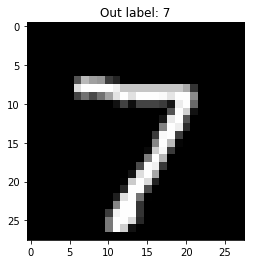

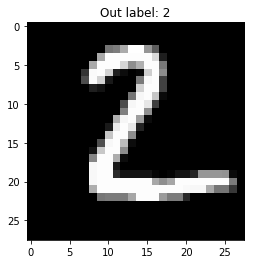

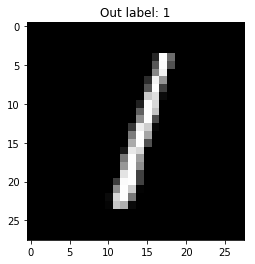

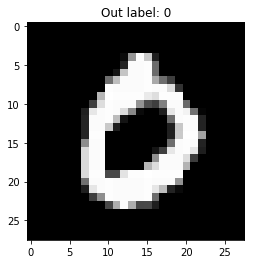

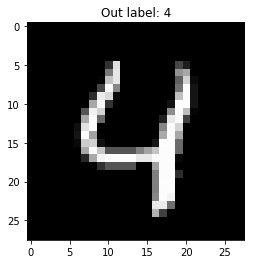

In [204]:
for i in range(X.shape[0]):
    img_title = ('Out label: %d' % np.argmax(np.array(y[i])))
    print_img(X[i], img_title)

In [201]:
N_callback = 500

X = np.load('./X_test.npy').astype(np.float32)
y = []
timea = time()
time0 = time()
for iXi, Xi in enumerate(X):
    X_new = encode_matrix(Xi)
    for i in range(392):
        in_mmio.write(4 * i, int(X_new[i]))
    y.append(get_output(ou_mmio))
    if (iXi % N_callback == 0) & (iXi != 0):
        time1 = time()
        print_dt(time0, time1, N_callback)
        time0 = time()

timeb = time()
print_dt(timea, timeb, X.shape[0])
np.save('y_pynq.npy', y)

Classified 500 images in 29.522790908813477 seconds (16.936068190312398 inferences / s)
----------------------------------------------------------------------------
0.05904558181762696 s/inference 
Classified 500 images in 28.389601707458496 seconds (17.61208223885157 inferences / s)
----------------------------------------------------------------------------
0.05677920341491699 s/inference 
Classified 500 images in 28.227139472961426 seconds (17.71344916047715 inferences / s)
----------------------------------------------------------------------------
0.05645427894592285 s/inference 
Classified 500 images in 28.20579504966736 seconds (17.726853617122085 inferences / s)
----------------------------------------------------------------------------
0.05641159009933471 s/inference 
Classified 500 images in 28.168015003204346 seconds (17.75062956843501 inferences / s)
----------------------------------------------------------------------------
0.05633603000640869 s/inference 
Classified 500